## Energy resolution to energy <a class="anchor" id="section-1"></a>
- [Energy resolution to energy](#section-1)
- [Time domain](#section-2)

[]
[]
[]
[785]
t1 = 722.0442580661534


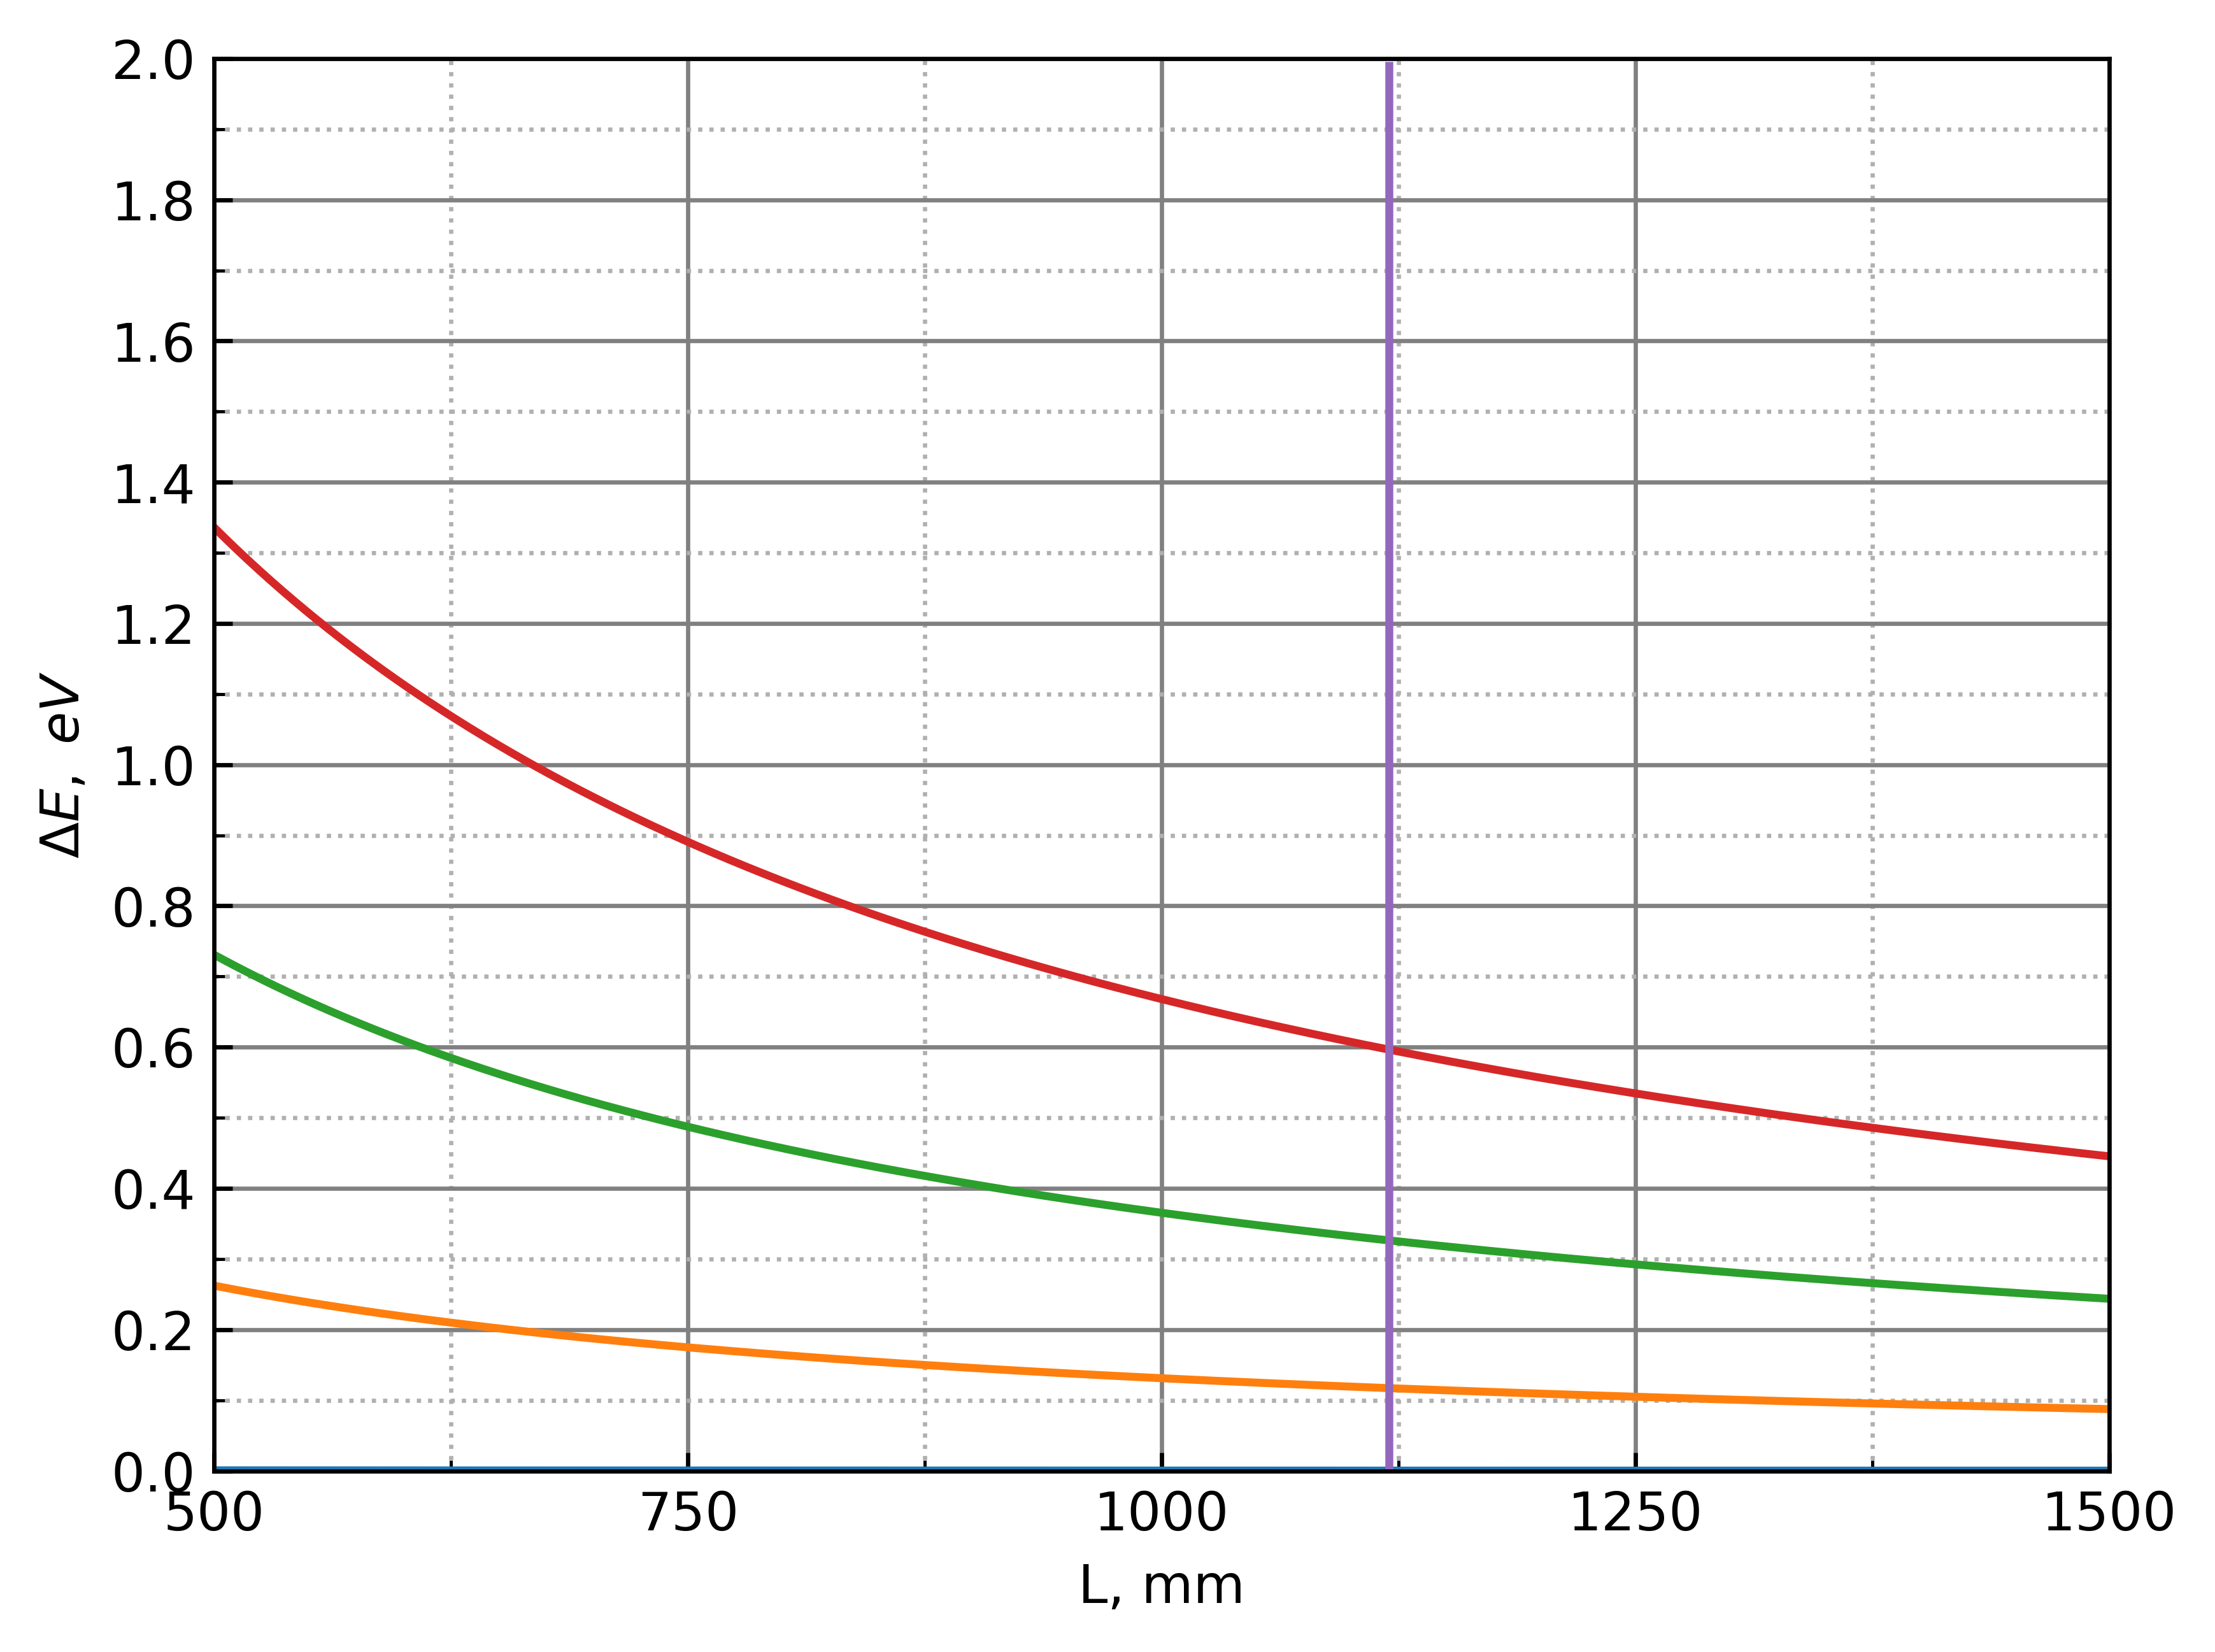

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from funcs import velocity, decorate, time_of_flight

fig, ax = plt.subplots(dpi=600)

x_start = 500
x_end = 1500
x_interval = 250
y_start = 0
y_end = 2
y_interval = 0.2

t_resolution = 0.30349e-9
x = np.arange(x_start, x_end, 1)
for E in range(1, 201, 50):
    g = 2*velocity(E)*t_resolution*E/x
    idx = np.argwhere(np.diff(np.sign(0.85 - g))).flatten()
    print(x[idx])
    ax.plot(x, g)
y = np.arange(y_start, y_end, 0.01)
ax.plot(1120+np.zeros(shape=(len(y),)), y)

decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval), 'L, mm', r"$\Delta E,~eV$")
print("t1 =", time_of_flight(6.84))

## Time domain <a class="anchor" id="section-2"></a>

-0.30349999999998545


,"Energy, eV","Theory, ns","Experiment, ns","Sigma, ns",Ex/Th
0,200,133.529392,133.631224,0.000002,1.000763
1,199,133.864473,133.904375,0.000016,1.000298
2,198,134.202088,134.207873,0.000018,1.000043
3,197,134.542272,134.632774,0.000009,1.000673
4,196,134.885055,134.875572,21.584750,0.999930
5,195,135.230472,135.209425,30.042614,0.999844
6,194,135.578556,135.543276,10.570251,0.999740
7,193,135.929342,135.937820,6.098102,1.000062
8,192,136.282865,136.271687,6.552805,0.999918


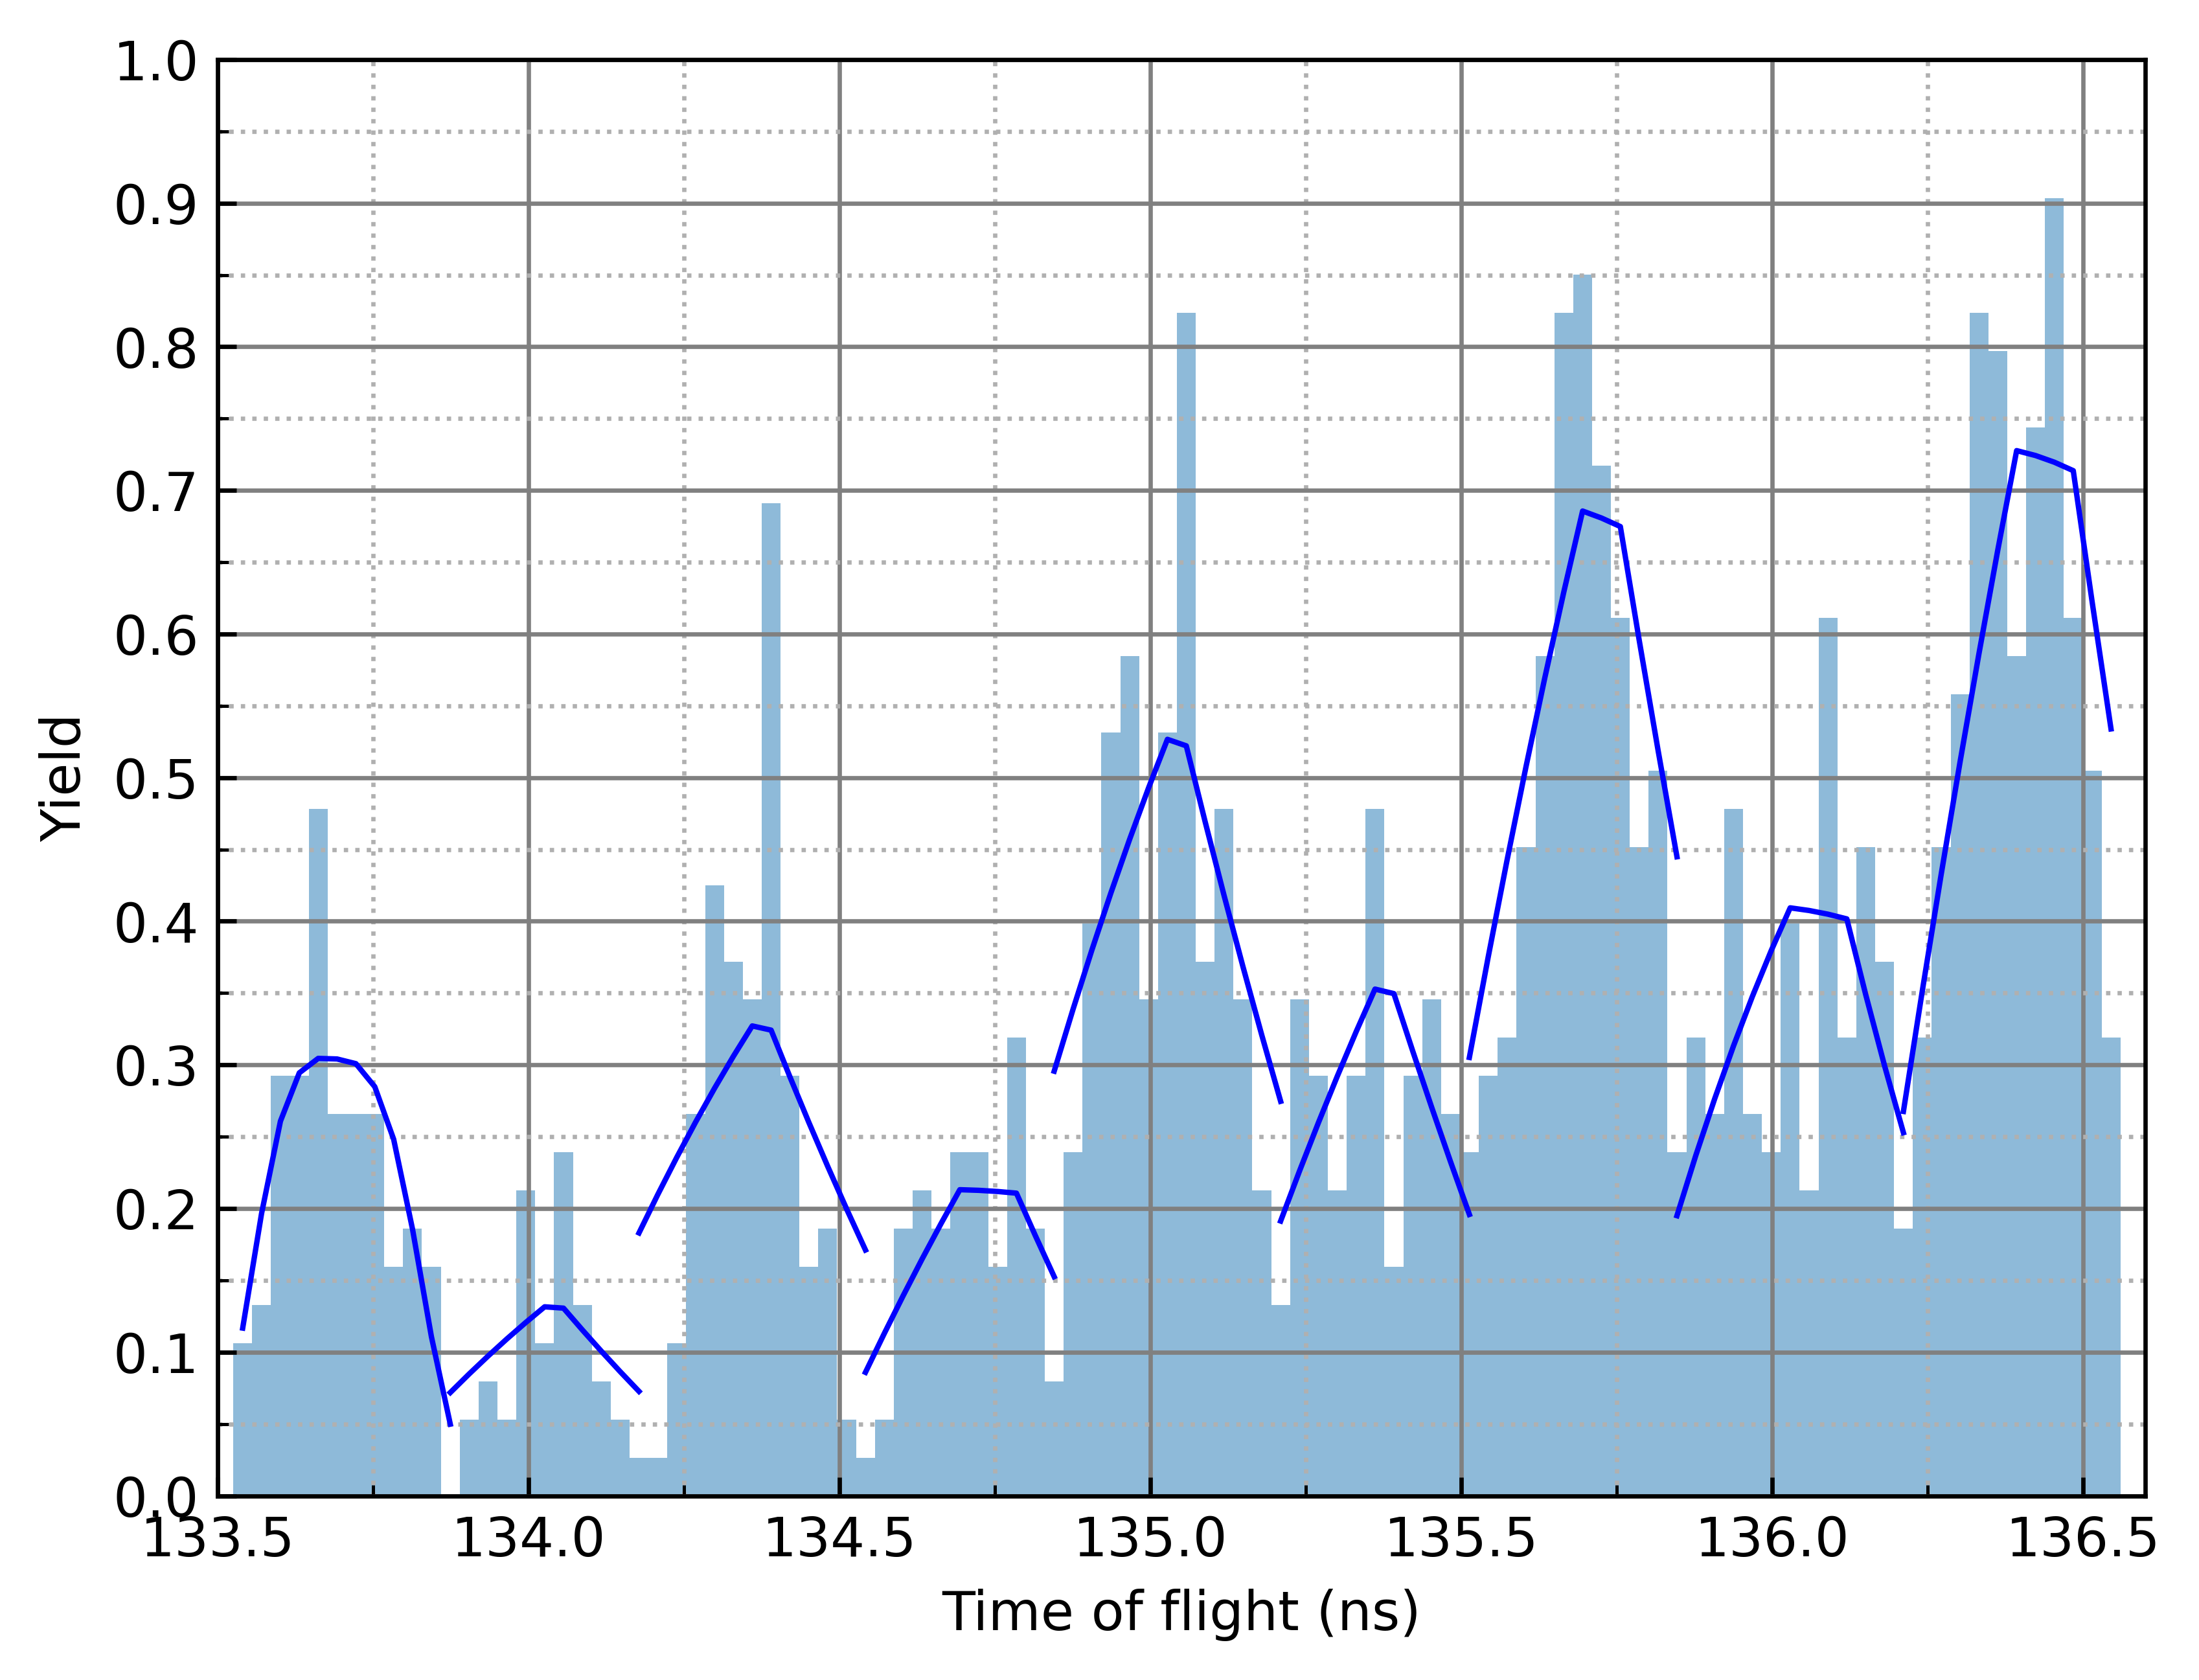

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from funcs import time_of_flight, decorate

x_start = 133.5
x_end = 136.6
x_interval = 0.5
y_start = 0
y_end = 1
y_interval = 0.1

fig, ax = plt.subplots(dpi=600)
d1 = []
d2 = []
with open("./data/6k.txt", 'r') as f:
    while True:
        s = f.readline()
        if s == '':
                break
        a = s.split()
        d1.append(float(a[0]))
        d2.append(float(a[1]))

decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"Time of flight (ns)", r"Yield")

y,x,_=hist(d1[:1240],100,alpha=.5, density=True)
x=(x[1:]+x[:-1])/2
with open("./data/ener.txt", mode="w") as file:
    for i in range(len(x)):
        file.write(f"{x[i]} {y[i]}\n")
def gauss(x, mu, sigma, A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def improved_gauss(x, x0, sigma, A, t):
    return np.convolve((A/2/np.pi/sigma)*np.exp(-(x-x0)**2/2/sigma**2),
                       np.exp(-(x-x0)/t)*np.heaviside(x-x0, 1), 'same')

res = 1.75/2.4

times = list()
sigmas = list()

def approx_gauss(x, y, p0):
    params,cov = curve_fit(improved_gauss, x, y, p0)
    sigma = sqrt(diag(cov))
    ax.plot(x, improved_gauss(x, *params), color='blue', lw=1)
    return (params[0], sigma[0])

p,s = approx_gauss(x[:12], y[:12], (time_of_flight(200), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[11:22], y[11:22], (time_of_flight(199), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[21:34], y[21:34], (time_of_flight(198), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[33:44], y[33:44], (time_of_flight(197), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[43:56], y[43:56], (time_of_flight(196), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[55:66], y[55:66], (time_of_flight(195), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[65:77], y[65:77], (time_of_flight(194), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[76:89], y[76:89], (time_of_flight(193), res, 0, 1))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x[88:], y[88:], (time_of_flight(192), res, 0, 1))
times.append(p)
sigmas.append(s)

def e(t):
     return (9.1093837e-31*(1.120/t/1e-9)**2)/2 * 6.242e+18

import pandas as pd
d = {
    "Energy, eV": [200, 199, 198, 197, 196, 195, 194, 193, 192],
    "Theory, ns": [	time_of_flight(200), time_of_flight(199), time_of_flight(198),
                    time_of_flight(197), time_of_flight(196), time_of_flight(195),
                    time_of_flight(194), time_of_flight(193), time_of_flight(192)],
    "Experiment, ns": [times[0], times[1], times[2], times[3], times[4],
                        times[5], times[6], times[7], times[8]],
    "Sigma, ns": [sigmas[0], sigmas[1], sigmas[2], sigmas[3],
                  sigmas[4], sigmas[5], sigmas[6], sigmas[7], sigmas[8]],
    "Ex/Th": [	times[0]/time_of_flight(200), times[1]/time_of_flight(199),
            	times[2]/time_of_flight(198), times[3]/time_of_flight(197),
				times[4]/time_of_flight(196), times[5]/time_of_flight(195),
				times[6]/time_of_flight(194), times[7]/time_of_flight(193),
				times[8]/time_of_flight(192)]
}
df = pd.DataFrame(data=d)
print(x[0]-x[10])
df

## Yield graph <a class="anchor" id="section-3"></a>

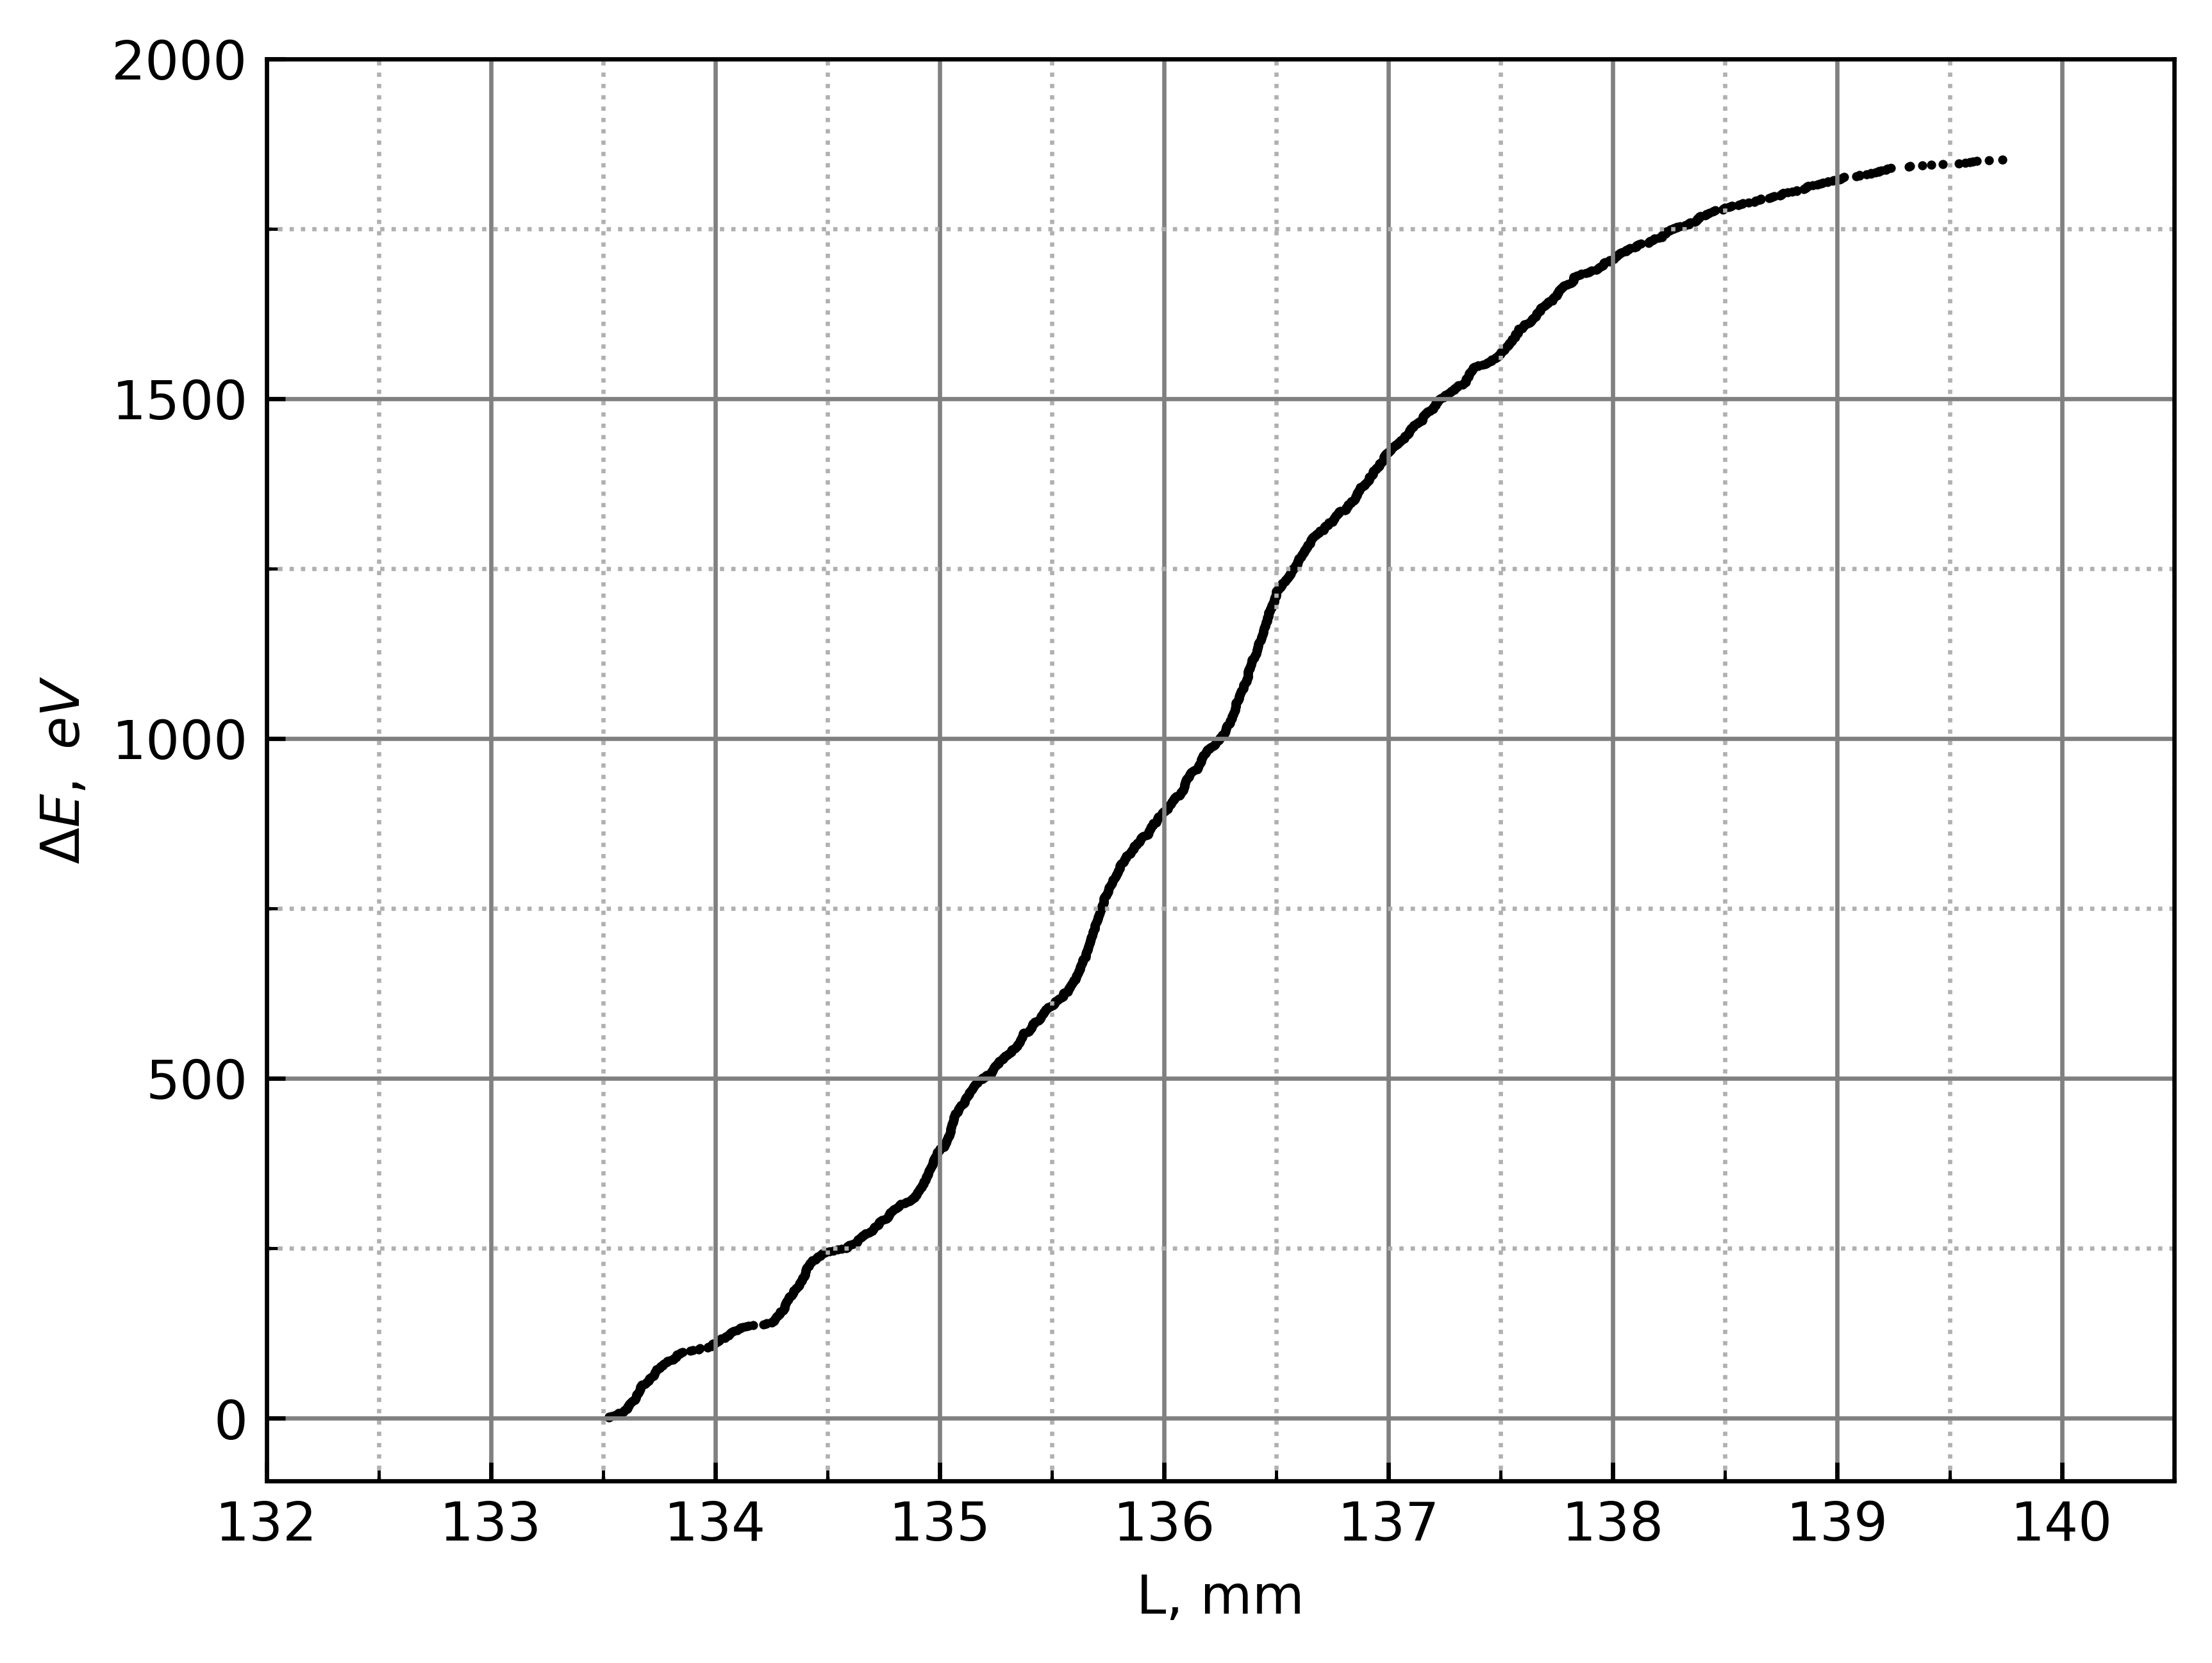

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x_start = 132
x_end = 140
x_interval = 1
y_start = 0
y_end = 2000
y_interval = 500

x = np.arange(x_start, x_end, 1)
fig, ax = plt.subplots()
fig.set_dpi(600)
d1 = []
d2=[]
with open("./data/6k.txt", 'r') as f:
    while True:
        s = f.readline()
        if s == '':
                break
        a = s.split()
        d1.append(float(a[0]))
        d2.append(float(a[1]))
ax.scatter(d1, d2, s=0.5, c="black") # np.ones(shape=(len(d1),))
ax.set_xlabel('L, mm')
ax.set_ylabel(r"$\Delta E,~eV$")
ax.tick_params(which = "both", direction = "in")
ax.grid(True, which="major", ls="-", c="gray")
ax.grid(True, which="minor", ls=":")
ax.set_xticks(np.arange(x_start, x_end+1, x_interval))
ax.set_xticks(np.arange(x_start, x_end+1, x_interval/2), minor=True)
ax.set_yticks(np.arange(y_start, y_end+1, y_interval))
ax.set_yticks(np.arange(y_start, y_end+1, y_interval/2), minor=True)

# ax.set(xlim=(x_start, x_end), ylim=(y_start, y_end))
print()

## Energy domain <a class="anchor" id="section-4"></a>


-0.8531622161379744


,"Energy, eV","Experiment, ns","Sigma, ns",Ex/Th
0,192,191.688351,0.027570,0.998377
1,193,192.638631,0.174750,0.998128
2,194,193.673255,0.017213,0.998316
3,195,194.595351,0.127276,0.997925
4,196,195.608095,0.041614,0.998000
5,197,196.487914,0.048662,0.997401
6,198,197.547322,0.033026,0.997714
7,199,198.500392,0.035092,0.997489
8,200,199.569226,0.036942,0.997846


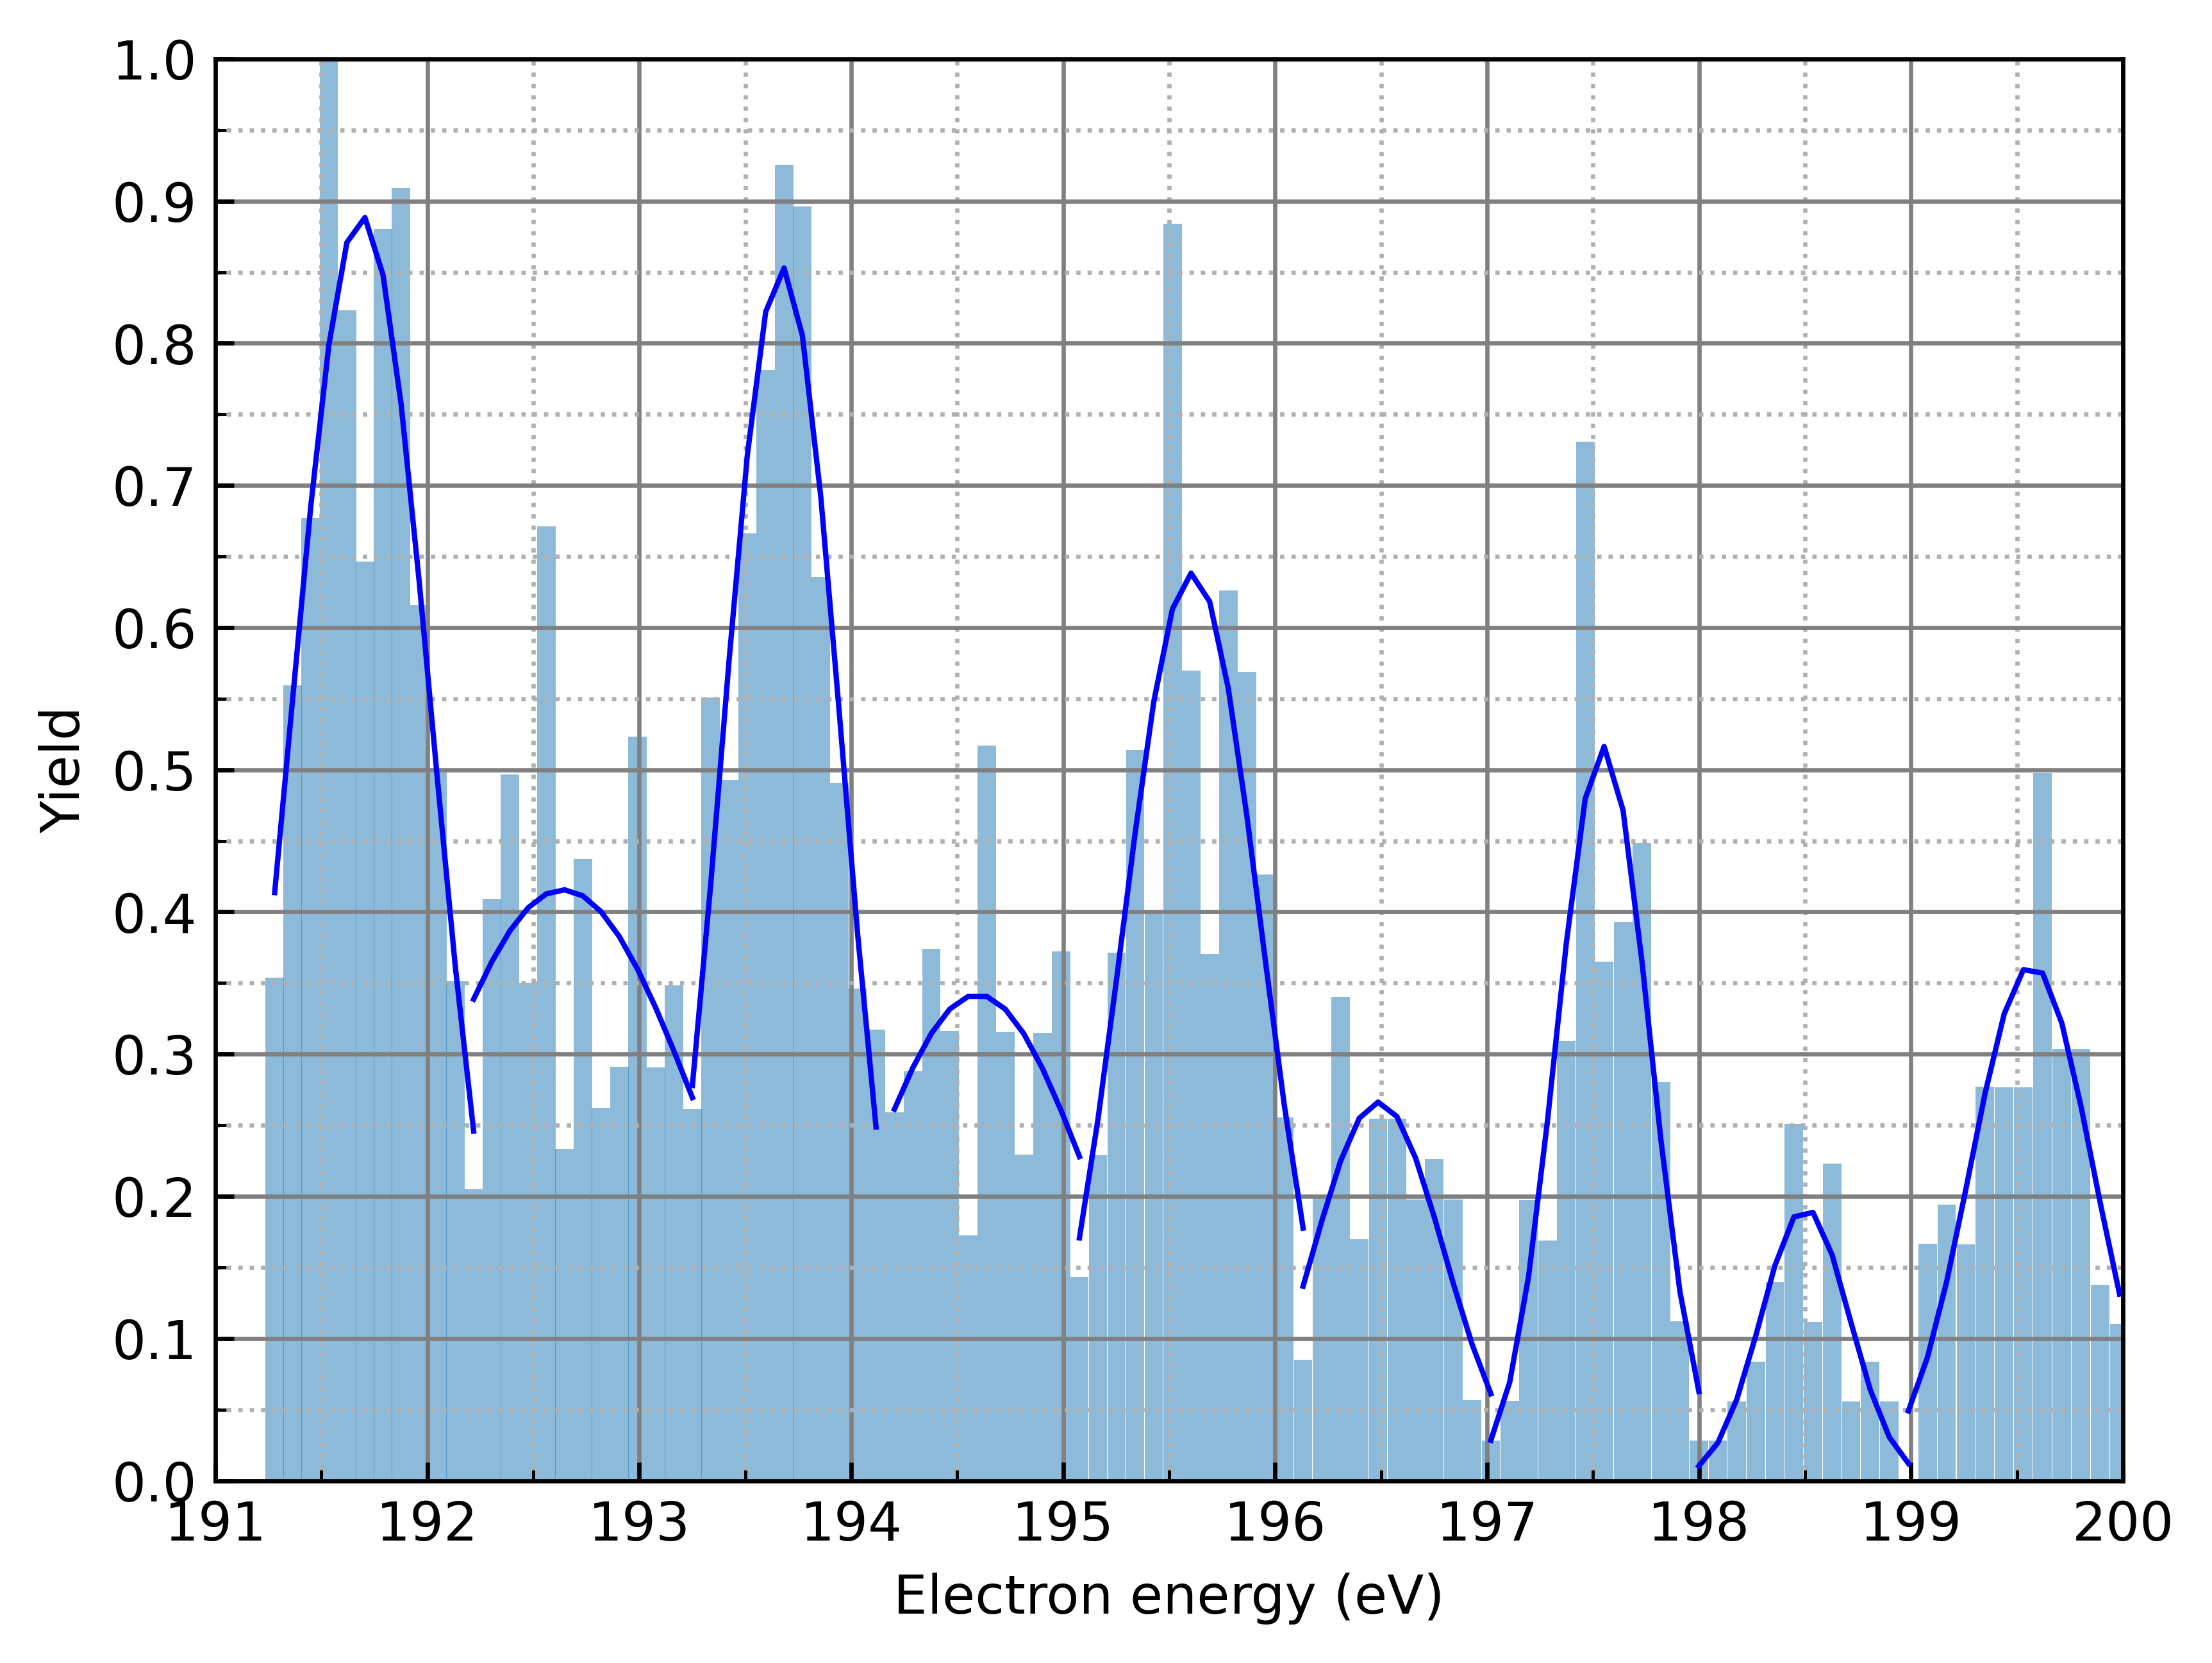

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x_start = 191
x_end = 200
x_interval = 1
y_start = 0
y_end = 1
y_interval = 0.1

x = np.arange(x_start, x_end, 1)
fig, ax = plt.subplots()
fig.set_dpi(600)
x = []
y = []
with open("./data/ener.txt", 'r') as f:
    while True:
        s = f.readline()
        if s == '':
                break
        a = s.split()
        x.append(float(a[0]))
        y.append(float(a[1]))
y /= np.max(y)

x_e = list()
y_e = list()

for i, el in enumerate(x):
     xx = (9.1093837e-31*(1.120/el/1e-9)**2)/2 # joules
     x_e.append(6.242e18 * xx) # ev

for i, el in enumerate(y):
     yy = el*1.120*np.sqrt(9.1093837e-31)/(2*x_e[i])**1.5
     y_e.append(yy)

x_e = x_e[::-1]
y_e = y_e[::-1]
y_e /= np.max(y_e)
ax.bar(x_e, y_e, width=(x_e[-1]-x_e[0])/100, alpha=0.5)

ax.set_xlabel(r"Electron energy (eV)")
ax.set_ylabel(r"Yield")
ax.tick_params(which = "both", direction = "in")
ax.grid(True, which="major", ls="-", c="gray")
ax.grid(True, which="minor", ls=":")
ax.set_xticks(np.arange(x_start, x_end+1, x_interval))
ax.set_xticks(np.arange(x_start, x_end+1, x_interval/2), minor=True)
ax.set_yticks(np.arange(y_start, y_end+1, y_interval))
ax.set_yticks(np.arange(y_start, y_end+1, y_interval/2), minor=True)

ax.set(xlim=(x_start, x_end), ylim=(y_start, y_end))
print()

def gauss(x, mu, sigma, A):
    return A*exp(-(x-mu)**2/2/sigma**2)

res = 1.75/2.4
def velocity(E):
    return np.sqrt(2*E*1.60218e-19/9.1093837e-31) * 1e3 # mm/s
def t(E): # ns
     return 1120/velocity(E)*1e9

times = list()
sigmas = list()

def approx_gauss(x, y, p0):
    params,cov = curve_fit(gauss, x, y, p0)
    sigma = sqrt(diag(cov))
    plot(x, gauss(x, *params), color='blue', lw=1)
    return (params[0], sigma[0])

p,s = approx_gauss(x_e[:12], y_e[:12], (192, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[11:24], y_e[11:24], (193, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[23:34], y_e[23:34], (194, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[34:45], y_e[34:45], (195, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[44:57], y_e[44:57], (196, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[56:67], y_e[56:67], (197, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[66:78], y_e[66:78], (198, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[77:89], y_e[77:89], (199, res, 0))
times.append(p)
sigmas.append(s)

p,s = approx_gauss(x_e[88:], y_e[88:], (200, res, 0))
times.append(p)
sigmas.append(s)

import pandas as pd
d = {
    "Energy, eV": [192, 193, 194, 195, 196, 197, 198, 199, 200],
    "Experiment, ns": [times[0], times[1], times[2], times[3], times[4],
                        times[5], times[6], times[7], times[8]],
    "Sigma, ns": [sigmas[0], sigmas[1], sigmas[2], sigmas[3],
                  sigmas[4], sigmas[5], sigmas[6], sigmas[7], sigmas[8]],
    "Ex/Th": [times[0]/192, times[1]/193, times[2]/194, times[3]/195,
              times[4]/196, times[5]/197, times[6]/198, times[7]/199, times[8]/200]
}
df = pd.DataFrame(data=d)
print(x_e[0]-x_e[10])
df

## Bundle's deviation <a class="anchor" id="section-5"></a>

[(191.0, 201.0), (0.0, 20.0)]

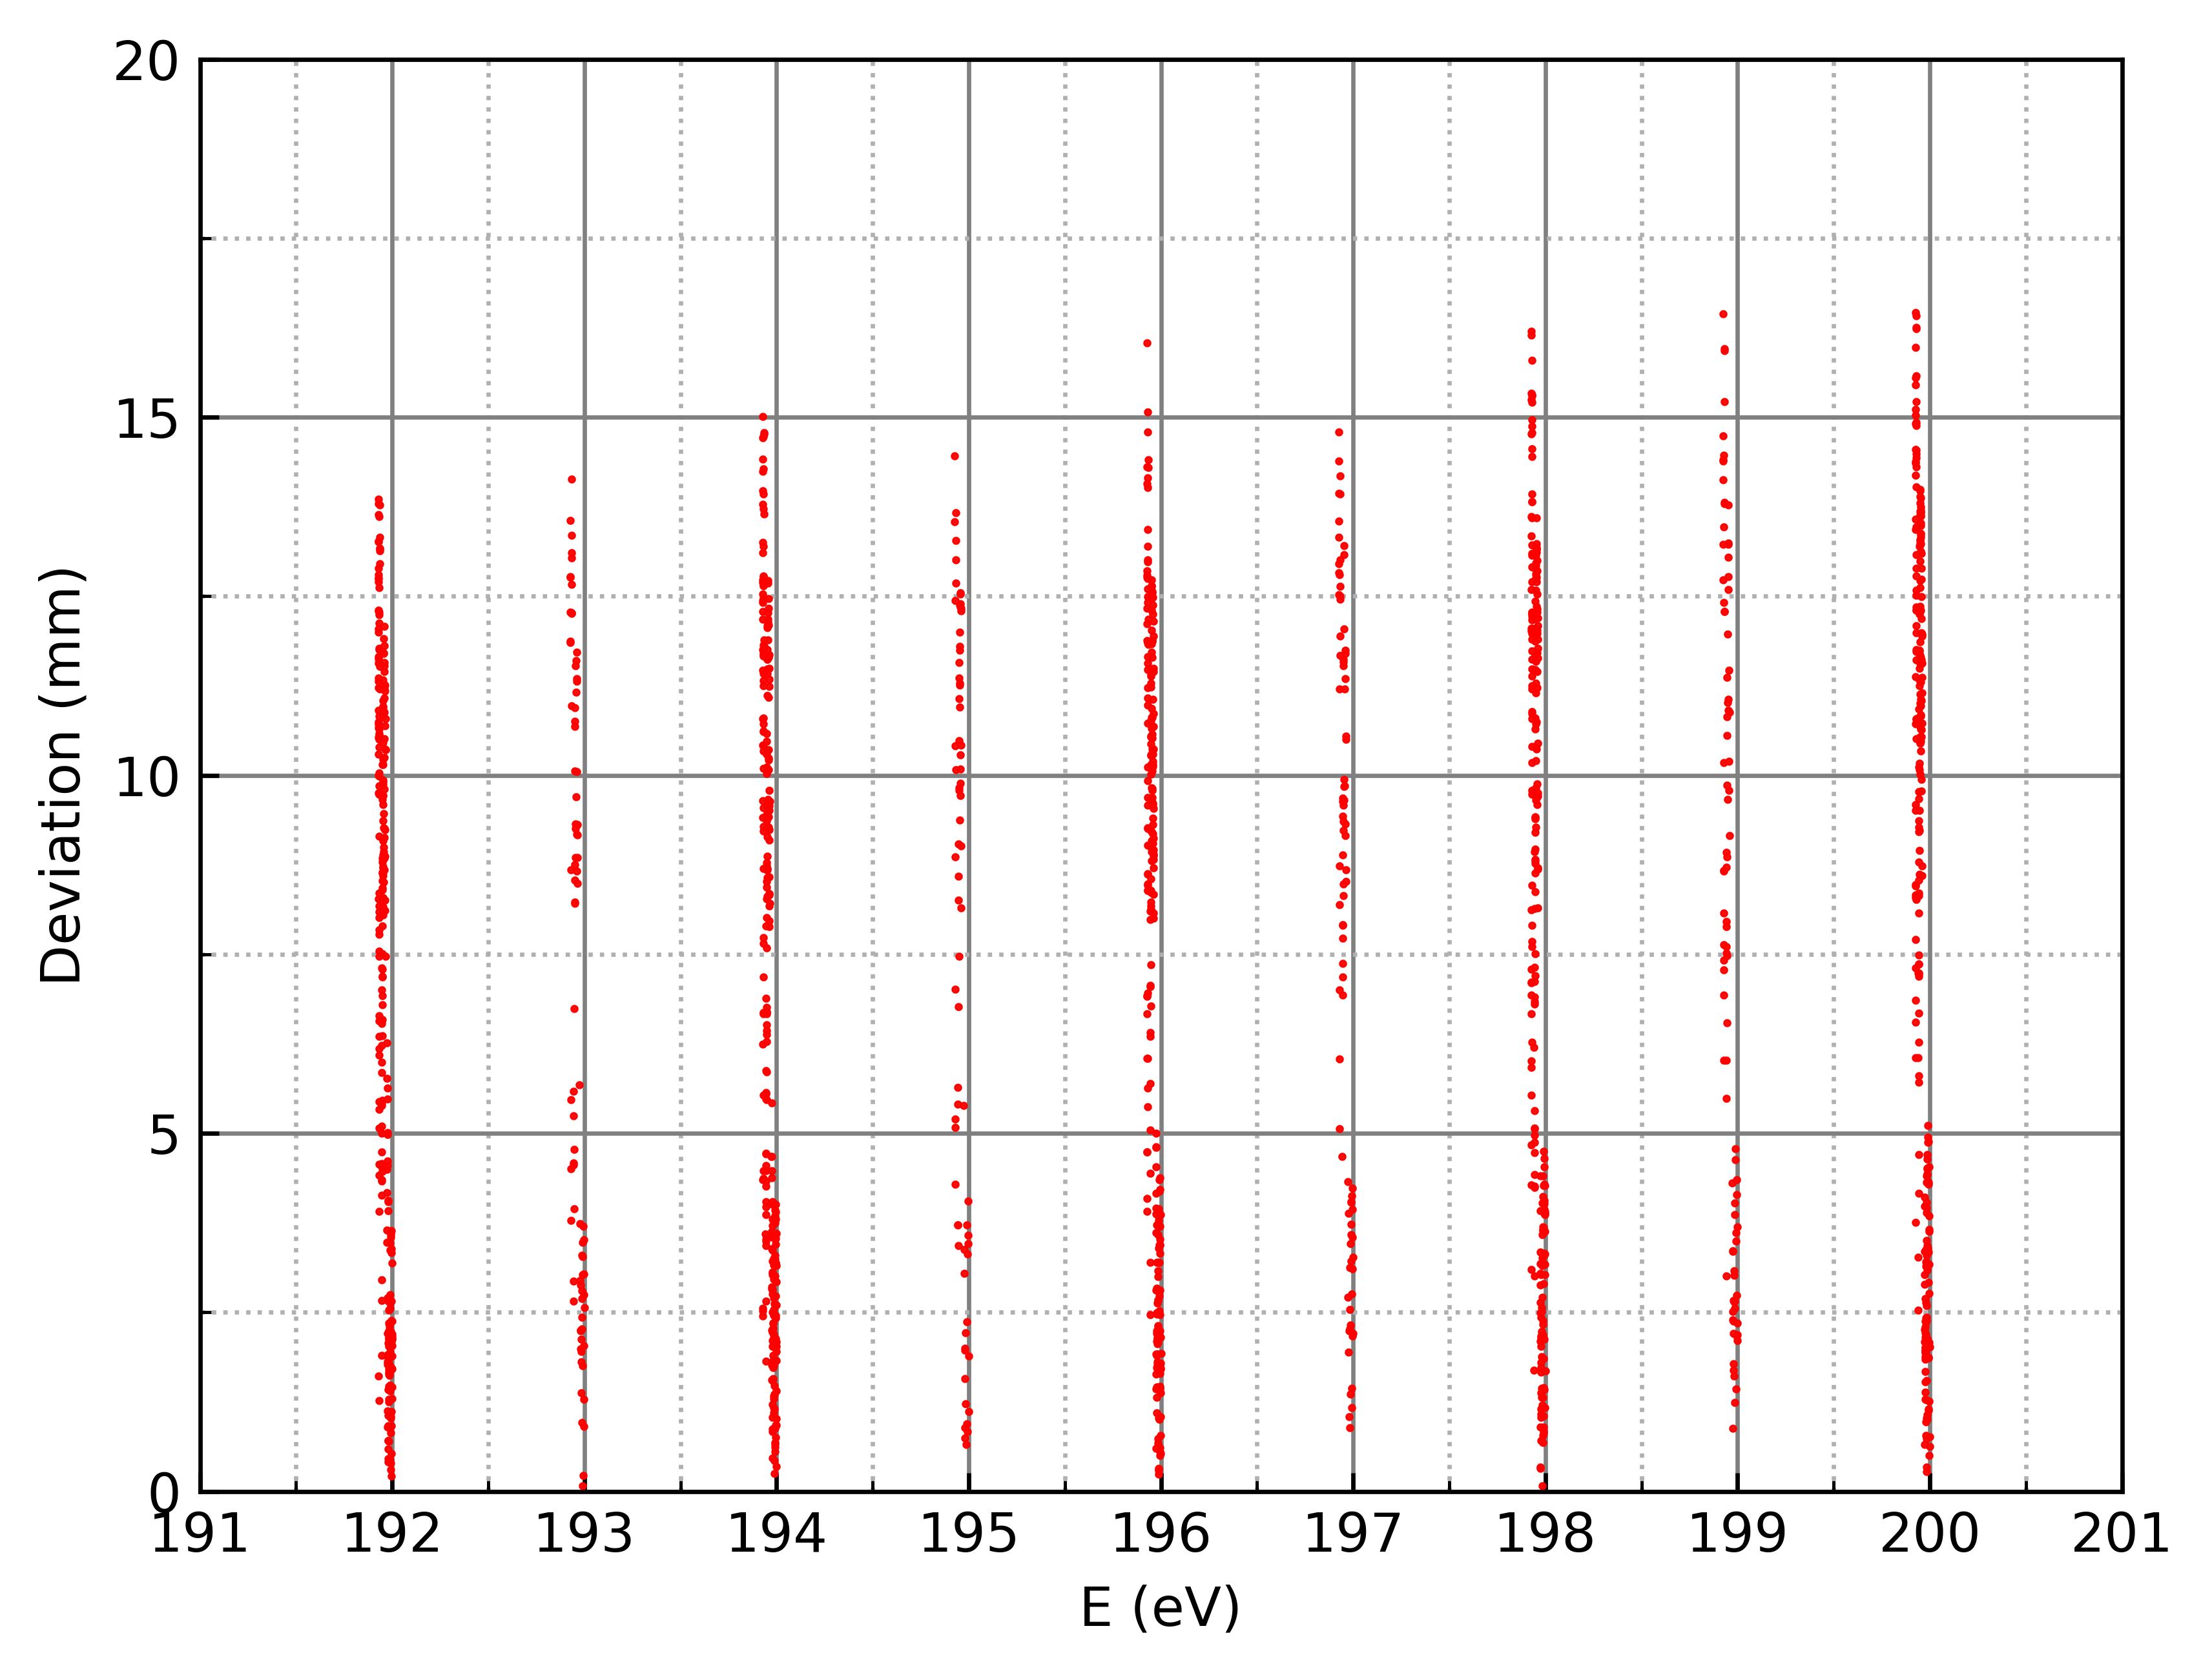

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_start = 191
x_end = 201
x_interval = 1
y_start = 0
y_end = 20
y_interval = 5

x = np.arange(x_start, x_end, 1)
fig, ax = plt.subplots()
fig.set_dpi(600)
e = []
r = []
with open("distance_1.txt", 'r') as f1:
    with open("distance.txt", 'r') as f:
        while True:
            s1 = f1.readline()
            s = f.readline()
            if s1 == '' or s == '':
                break
            a1 = s1.split()
            a = s.split()
            if float(a1[2]) == 1100.0:
                r.append(np.sqrt(float(a1[1])**2 + float(a1[3])**2))
                e.append(float(a[1]))

ax.scatter(e, r, s=0.25, c='red', zorder=2)

ax.set_xlabel(r"E (eV)")
ax.set_ylabel(r"Deviation (mm)")
ax.tick_params(which = "both", direction = "in")
ax.grid(True, which="major", ls="-", c="gray")
ax.grid(True, which="minor", ls=":")
ax.set_xticks(np.arange(x_start, x_end+1, x_interval))
ax.set_xticks(np.arange(x_start, x_end+1, x_interval/2), minor=True)
ax.set_yticks(np.arange(y_start, y_end+1, y_interval))
ax.set_yticks(np.arange(y_start, y_end+1, y_interval/2), minor=True)
#y=0.3125x-46
ax.set(xlim=(x_start, x_end), ylim=(y_start, y_end))

## Fourier transform <a class="anchor" id="section-6"></a>

[46 92]
[133.664725 134.006275 134.347825 134.689375 135.030925 135.372475
 135.714025 136.055575 136.366075 136.707625 137.049175 137.639125
 138.260125 138.570625 138.912175 139.253725 139.533175]
[1.00101351 1.0010593  1.00108595 1.00109336 1.00108144 1.00105008
 1.00099919 1.00092867 1.00061057]


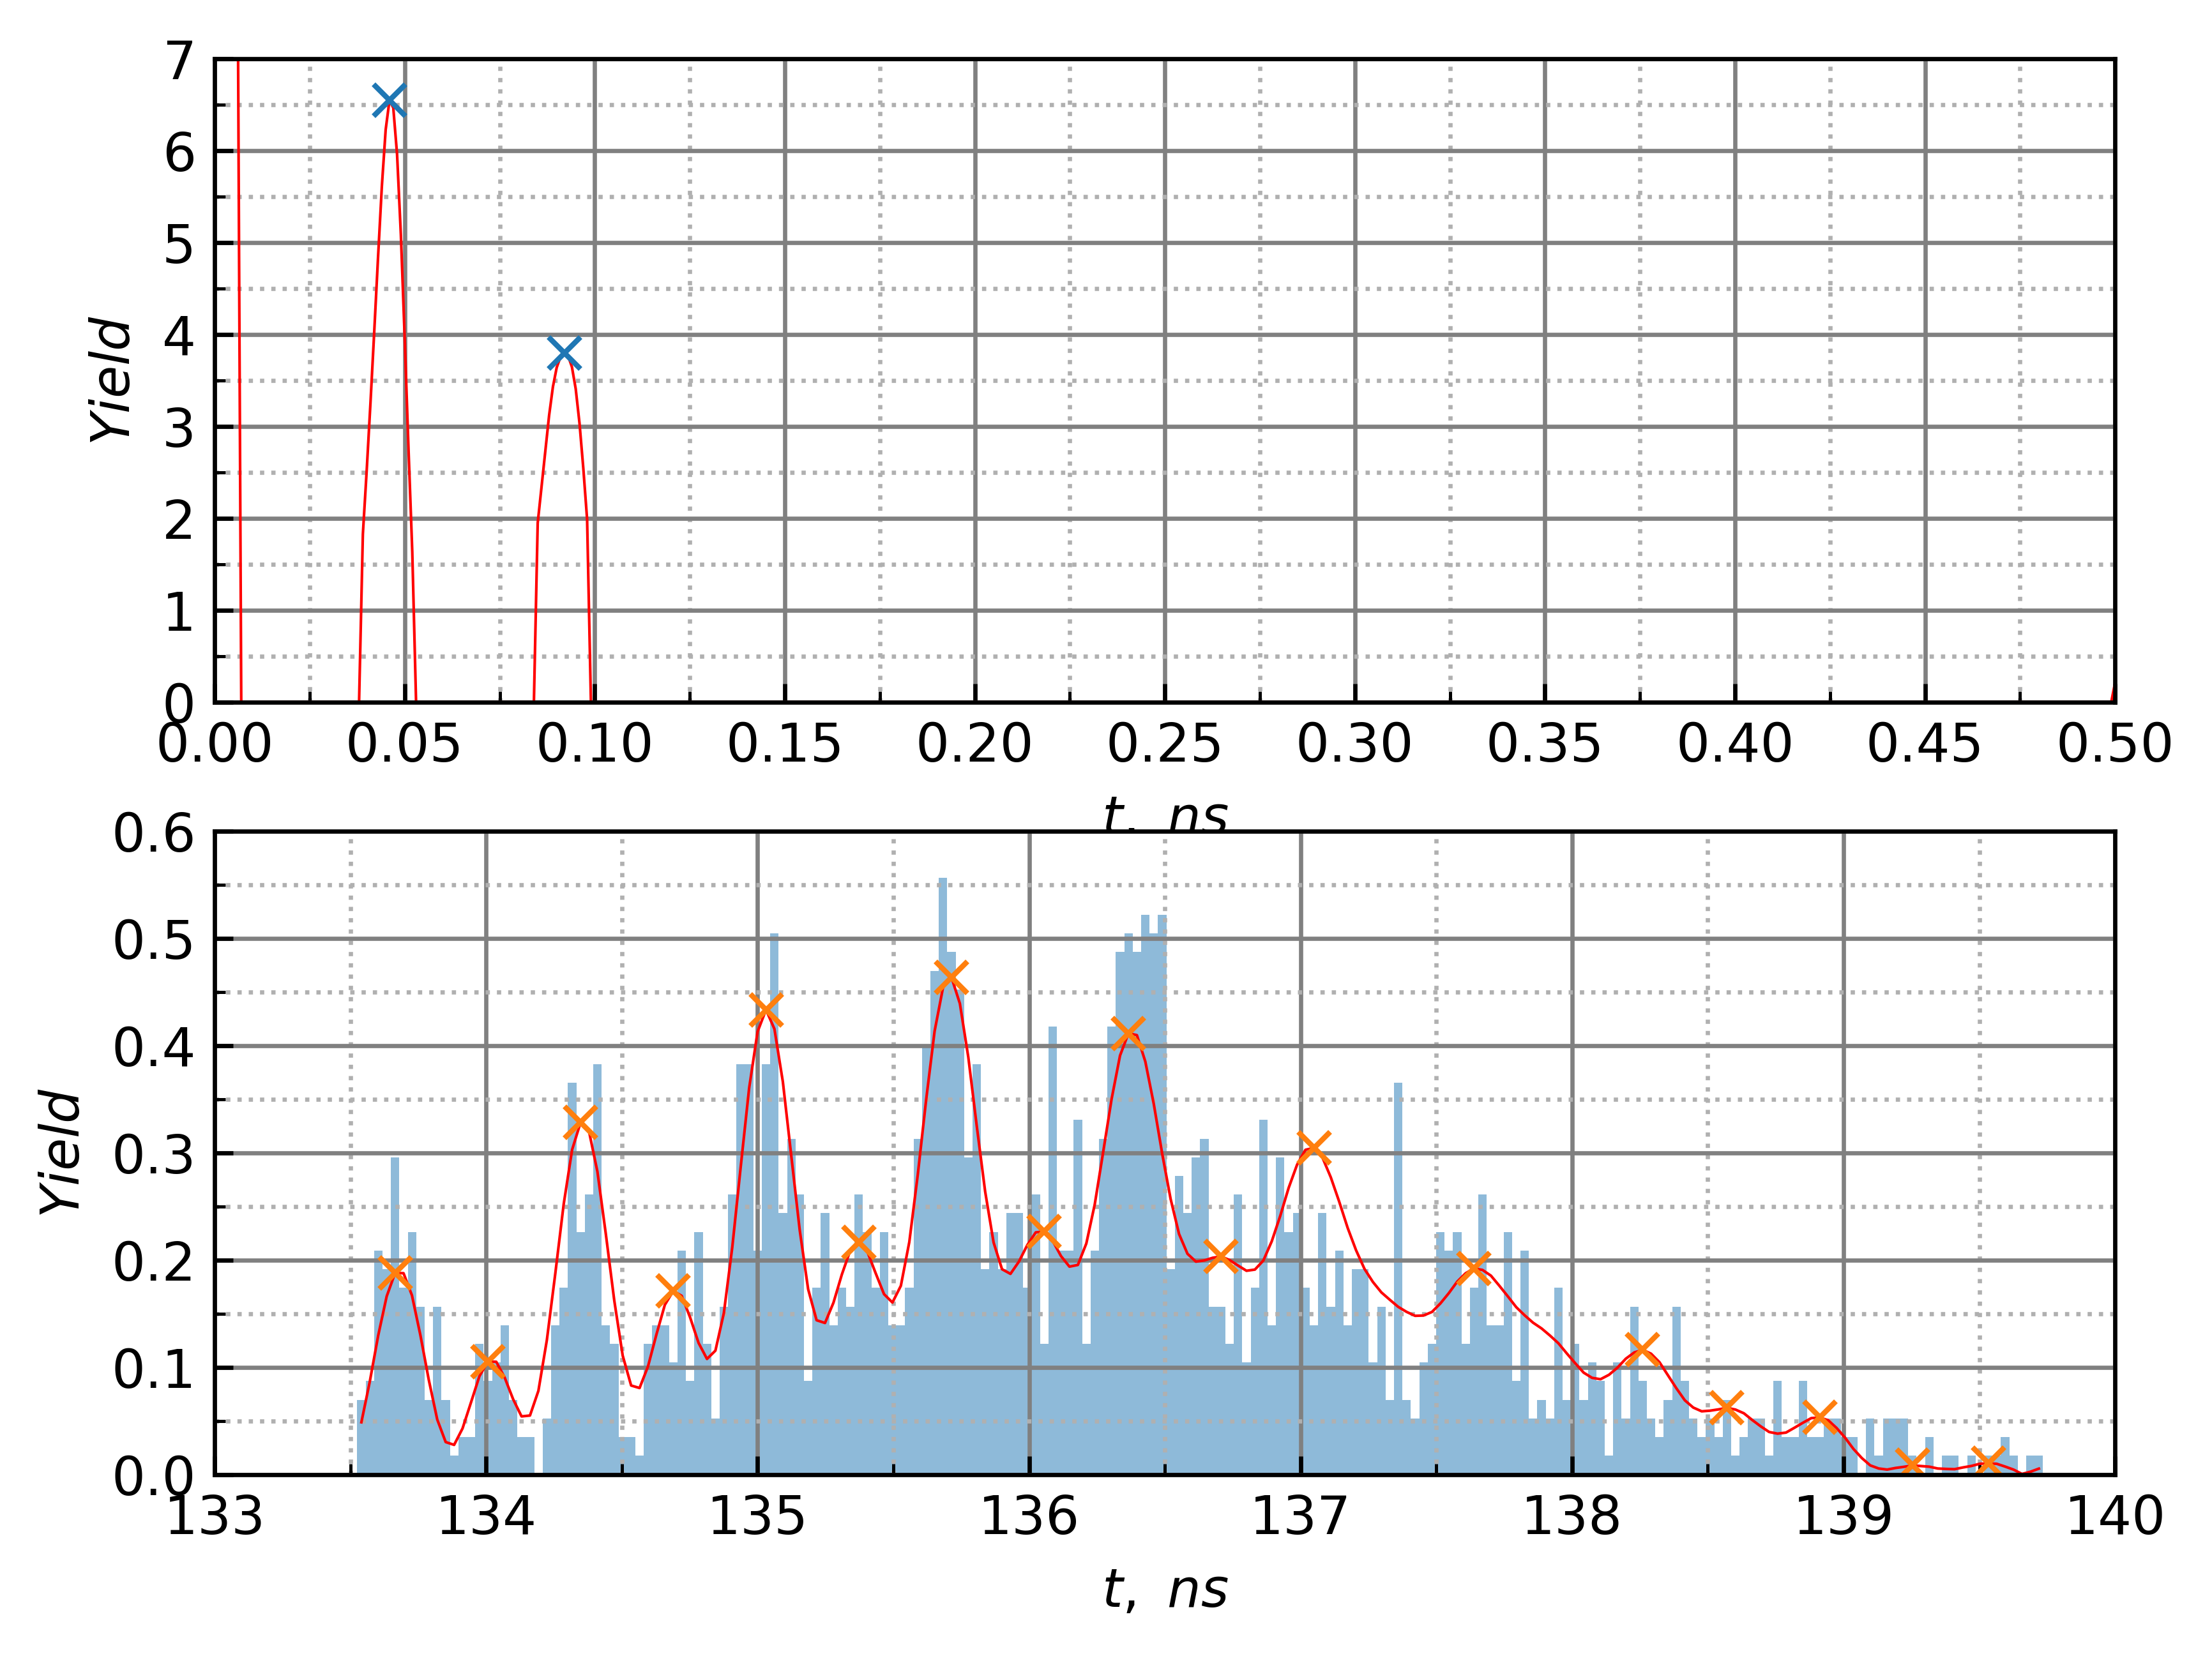

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import find_peaks

x = np.arange(x_start, x_end, 1)
fig, axs = plt.subplots(nrows=2)
fig.set_dpi(600)

d1 = []
b = []
with open("6k_hist.txt", 'r') as f:
    while True:
        s = f.readline()
        if s == '':
                break
        a = s.split()
        d1.append(float(a[0]))
        b.append(float(a[1]))
for i, ax in enumerate(axs):
    if i == 1:
        x_start = 133
        x_end = 140
        x_interval = 1
        y_start = 0
        y_end = 0.6
        y_interval = 0.1
    else:
        x_start = 0
        x_end = 0.5
        x_interval = 0.05
        y_start = 0
        y_end = 7
        y_interval = 1
    ax.set_xlabel(r"$t,~ns$")
    ax.set_ylabel(r"$Yield$")
    ax.tick_params(which = "both", direction = "in")
    ax.grid(True, which="major", ls="-", c="gray")
    ax.grid(True, which="minor", ls=":")
    ax.set_xticks(np.arange(x_start, x_end+1, x_interval))
    ax.set_xticks(np.arange(x_start, x_end+1, x_interval/2), minor=True)
    ax.set_yticks(np.arange(y_start, y_end+1, y_interval))
    ax.set_yticks(np.arange(y_start, y_end+1, y_interval/2), minor=True)
    ax.set(xlim=(x_start, x_end), ylim=(y_start, y_end))

n = 200
y,x,_= hist(d1,n,alpha=.5, density=True)
x=(x[1:]+x[:-1])/2

N = 1000
yf = rfft(y, N)
xf = rfftfreq(N)
lows,_ = find_peaks(np.abs(yf[:n]), height=3)
print(lows)
yf[7:lows[0]-7] = 0
yf[lows[0]+7:lows[1]-7] = 0
yf[lows[1]+7:-1] = 0
iyf = irfft(yf)

axs[0].plot(xf, np.abs(yf), lw=0.5, c='red')
axs[1].plot(x, np.abs(iyf[:n]), lw=0.5, c='red')

axs[0].plot(xf[lows], np.abs(yf[lows]), "x")
peaks,_ = find_peaks(np.abs(iyf[:n]), height=0)
print(x[peaks])
axs[1].plot(x[peaks], np.abs(iyf[peaks]), "x")

def velocity(E):
    return np.sqrt(2*E*1.60218e-19/9.1093837e-31) * 1e3 # mm/s
def t(E): # ns
     return 1120/velocity(E)*1e9

tts = [t(200), t(199), t(198), t(197), t(196), t(195), t(194), t(193), t(192)]
print(x[peaks][:9]/tts)
# [1.00101351 1.0010593  1.00108595 1.00109336 1.00108144 1.00105008
# 1.00099919 1.00092867 1.0008384 ]
# [1.00101351 1.0010593  1.00108595 1.00109336 1.00108144 1.00105008
# 1.00099919 1.00070024 1.00061057]

## Energy resolution <a class="anchor" id="section-7"></a>

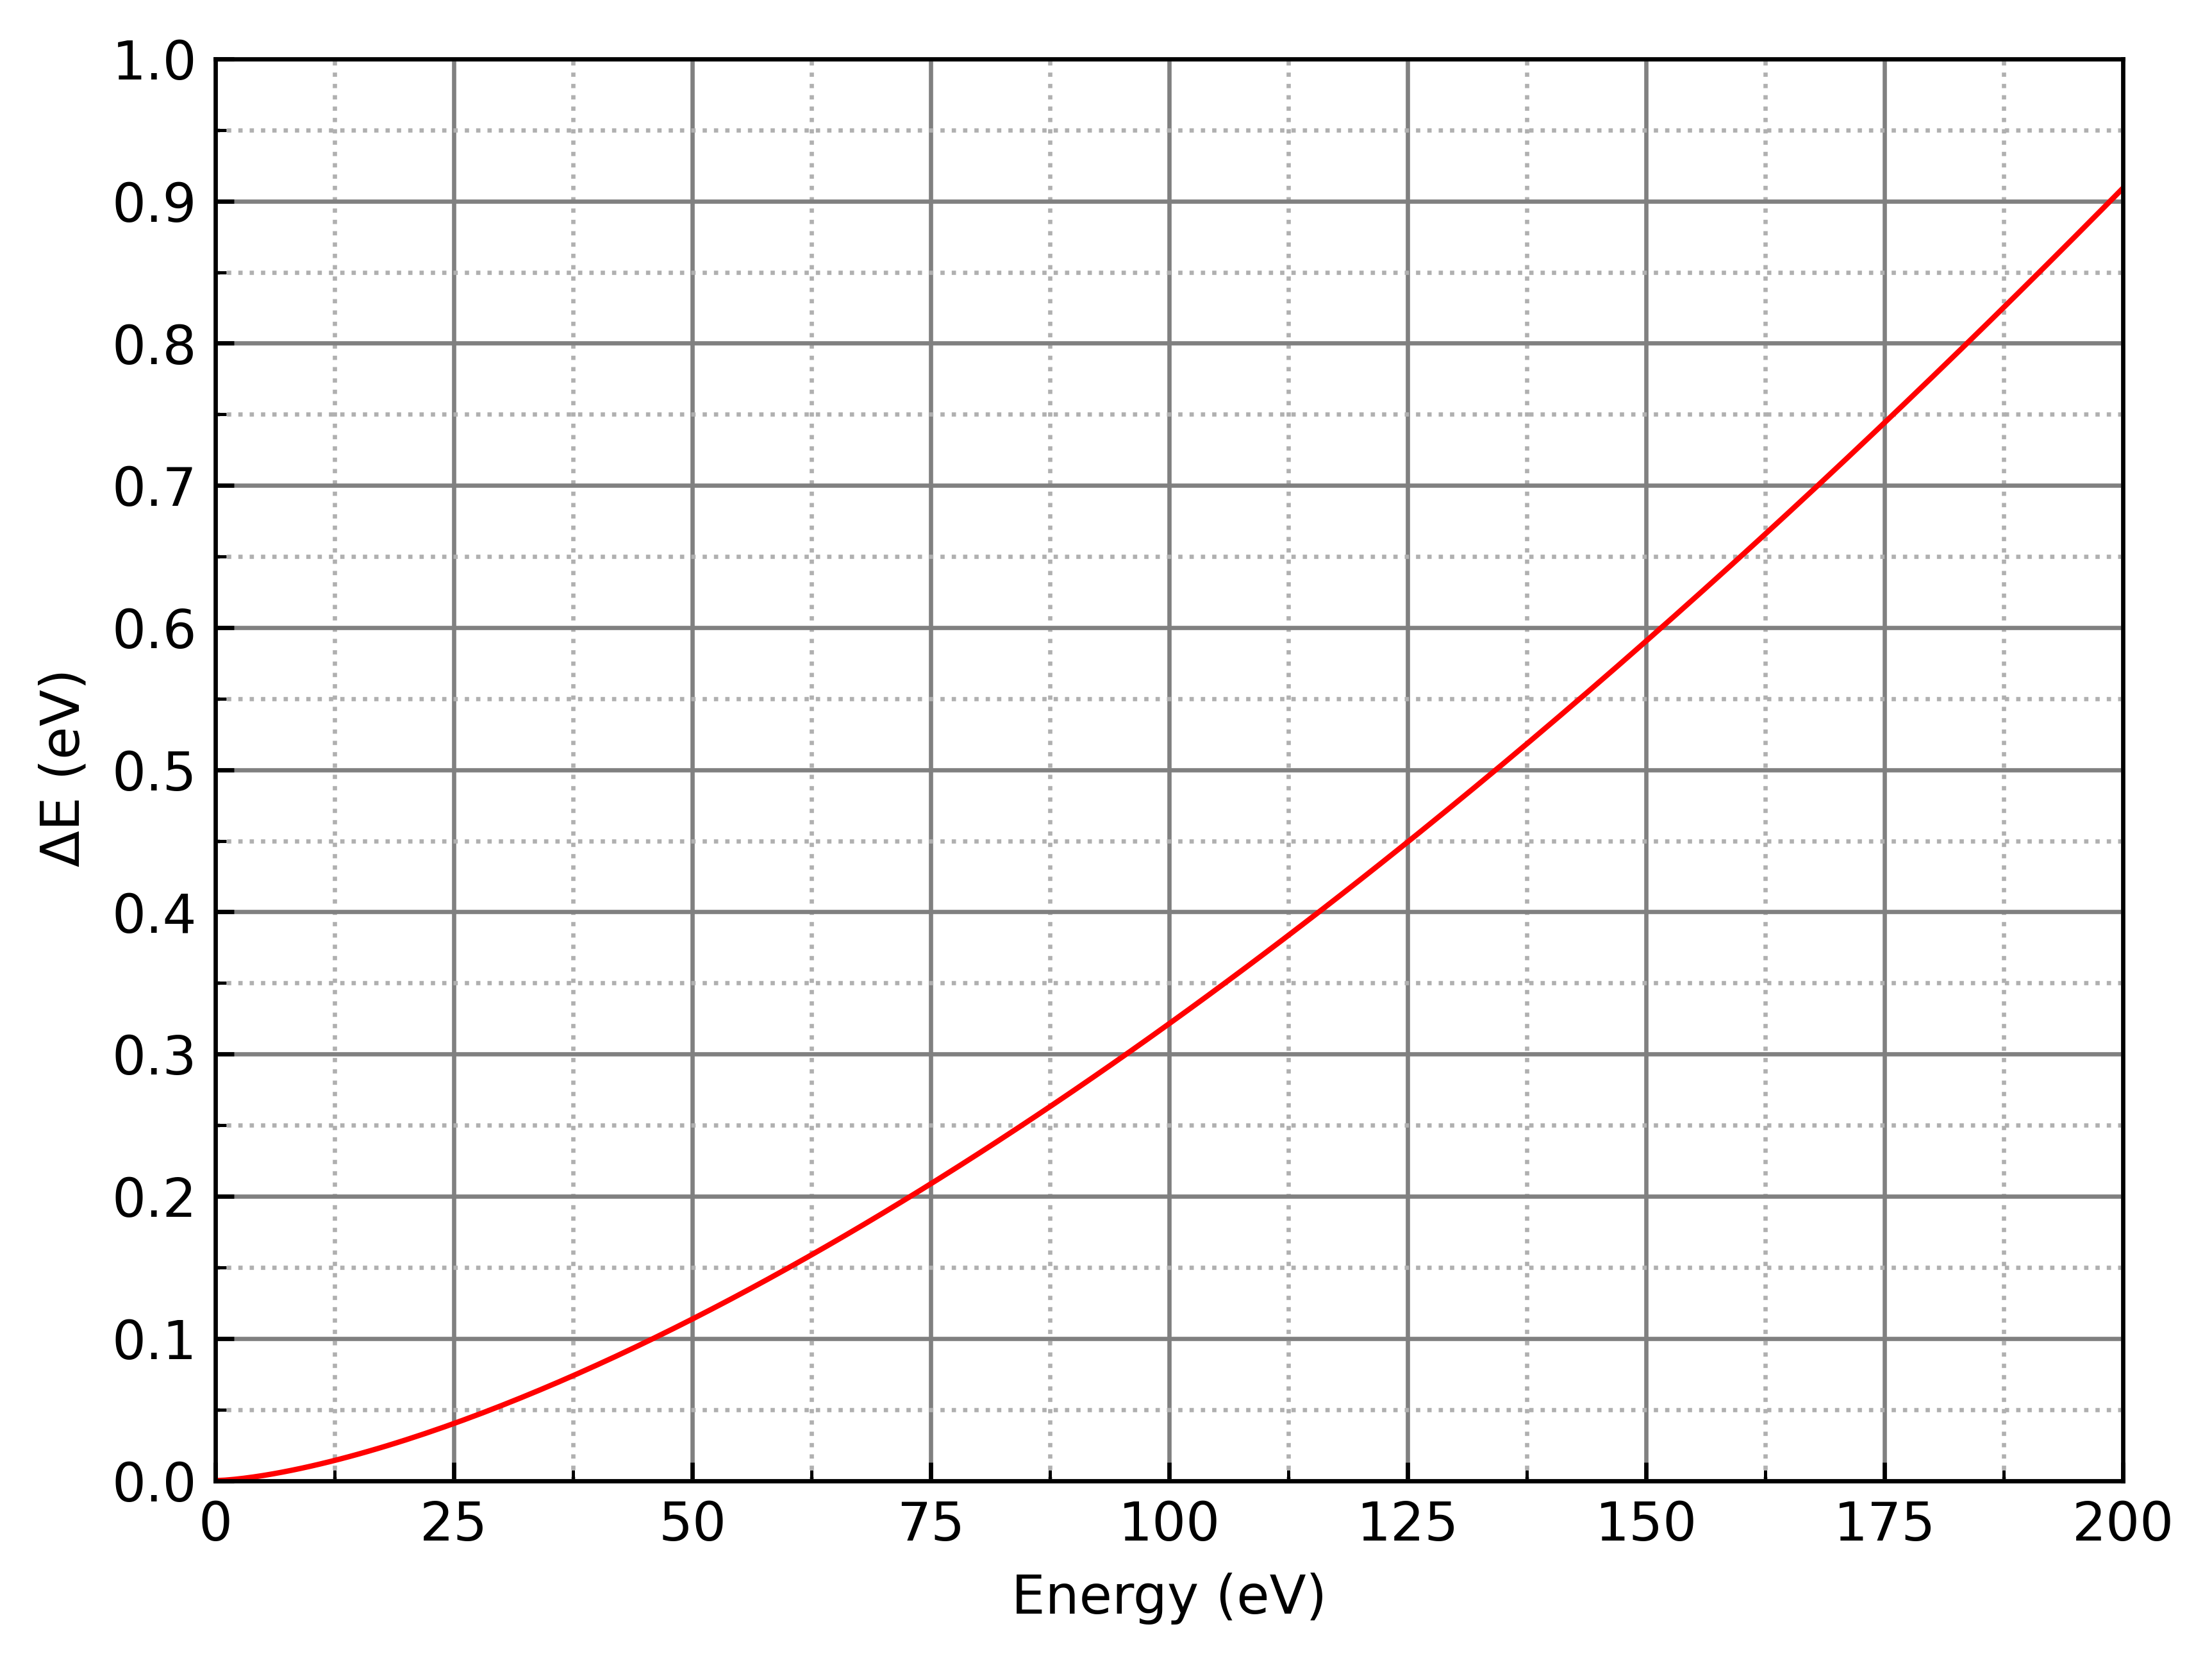

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def velocity(E):
    return np.sqrt(2*E*1.60218e-19/9.1093837e-31) * 1e3 # mm/s

x_start = 0
x_end = 200
x_interval = 25
y_start = 0
y_end = 1
y_interval = 0.1

E = np.arange(x_start, x_end+1, 1)
fig, ax = plt.subplots()
fig.set_dpi(600)
ax.plot(E, 2*velocity(E)*0.30349e-9*E/1120, c='red', lw=1)

ax.set_xlabel(r"Energy (eV)")
ax.set_ylabel(r"$\Delta$E (eV)")
ax.tick_params(which = "both", direction = "in")
ax.grid(True, which="major", ls="-", c="gray")
ax.grid(True, which="minor", ls=":")
ax.set_xticks(np.arange(x_start, x_end+1, x_interval))
ax.set_xticks(np.arange(x_start, x_end+1, x_interval/2), minor=True)
ax.set_yticks(np.arange(y_start, y_end+1, y_interval))
ax.set_yticks(np.arange(y_start, y_end+1, y_interval/2), minor=True)

ax.set(xlim=(x_start, x_end), ylim=(y_start, y_end))
print()

## 23.76eV single peak <a class="anchor" id="section-8"></a>

C:\Users\ppeli\AppData\Local\Temp\ipykernel_22096\3481693139.py:41: PeakPropertyWarning: some peaks have a prominence of 0
  results_half = peak_widths(new_y, (0,), rel_height=0.5)
C:\Users\ppeli\AppData\Local\Temp\ipykernel_22096\3481693139.py:41: PeakPropertyWarning: some peaks have a width of 0
  results_half = peak_widths(new_y, (0,), rel_height=0.5)


[0.]


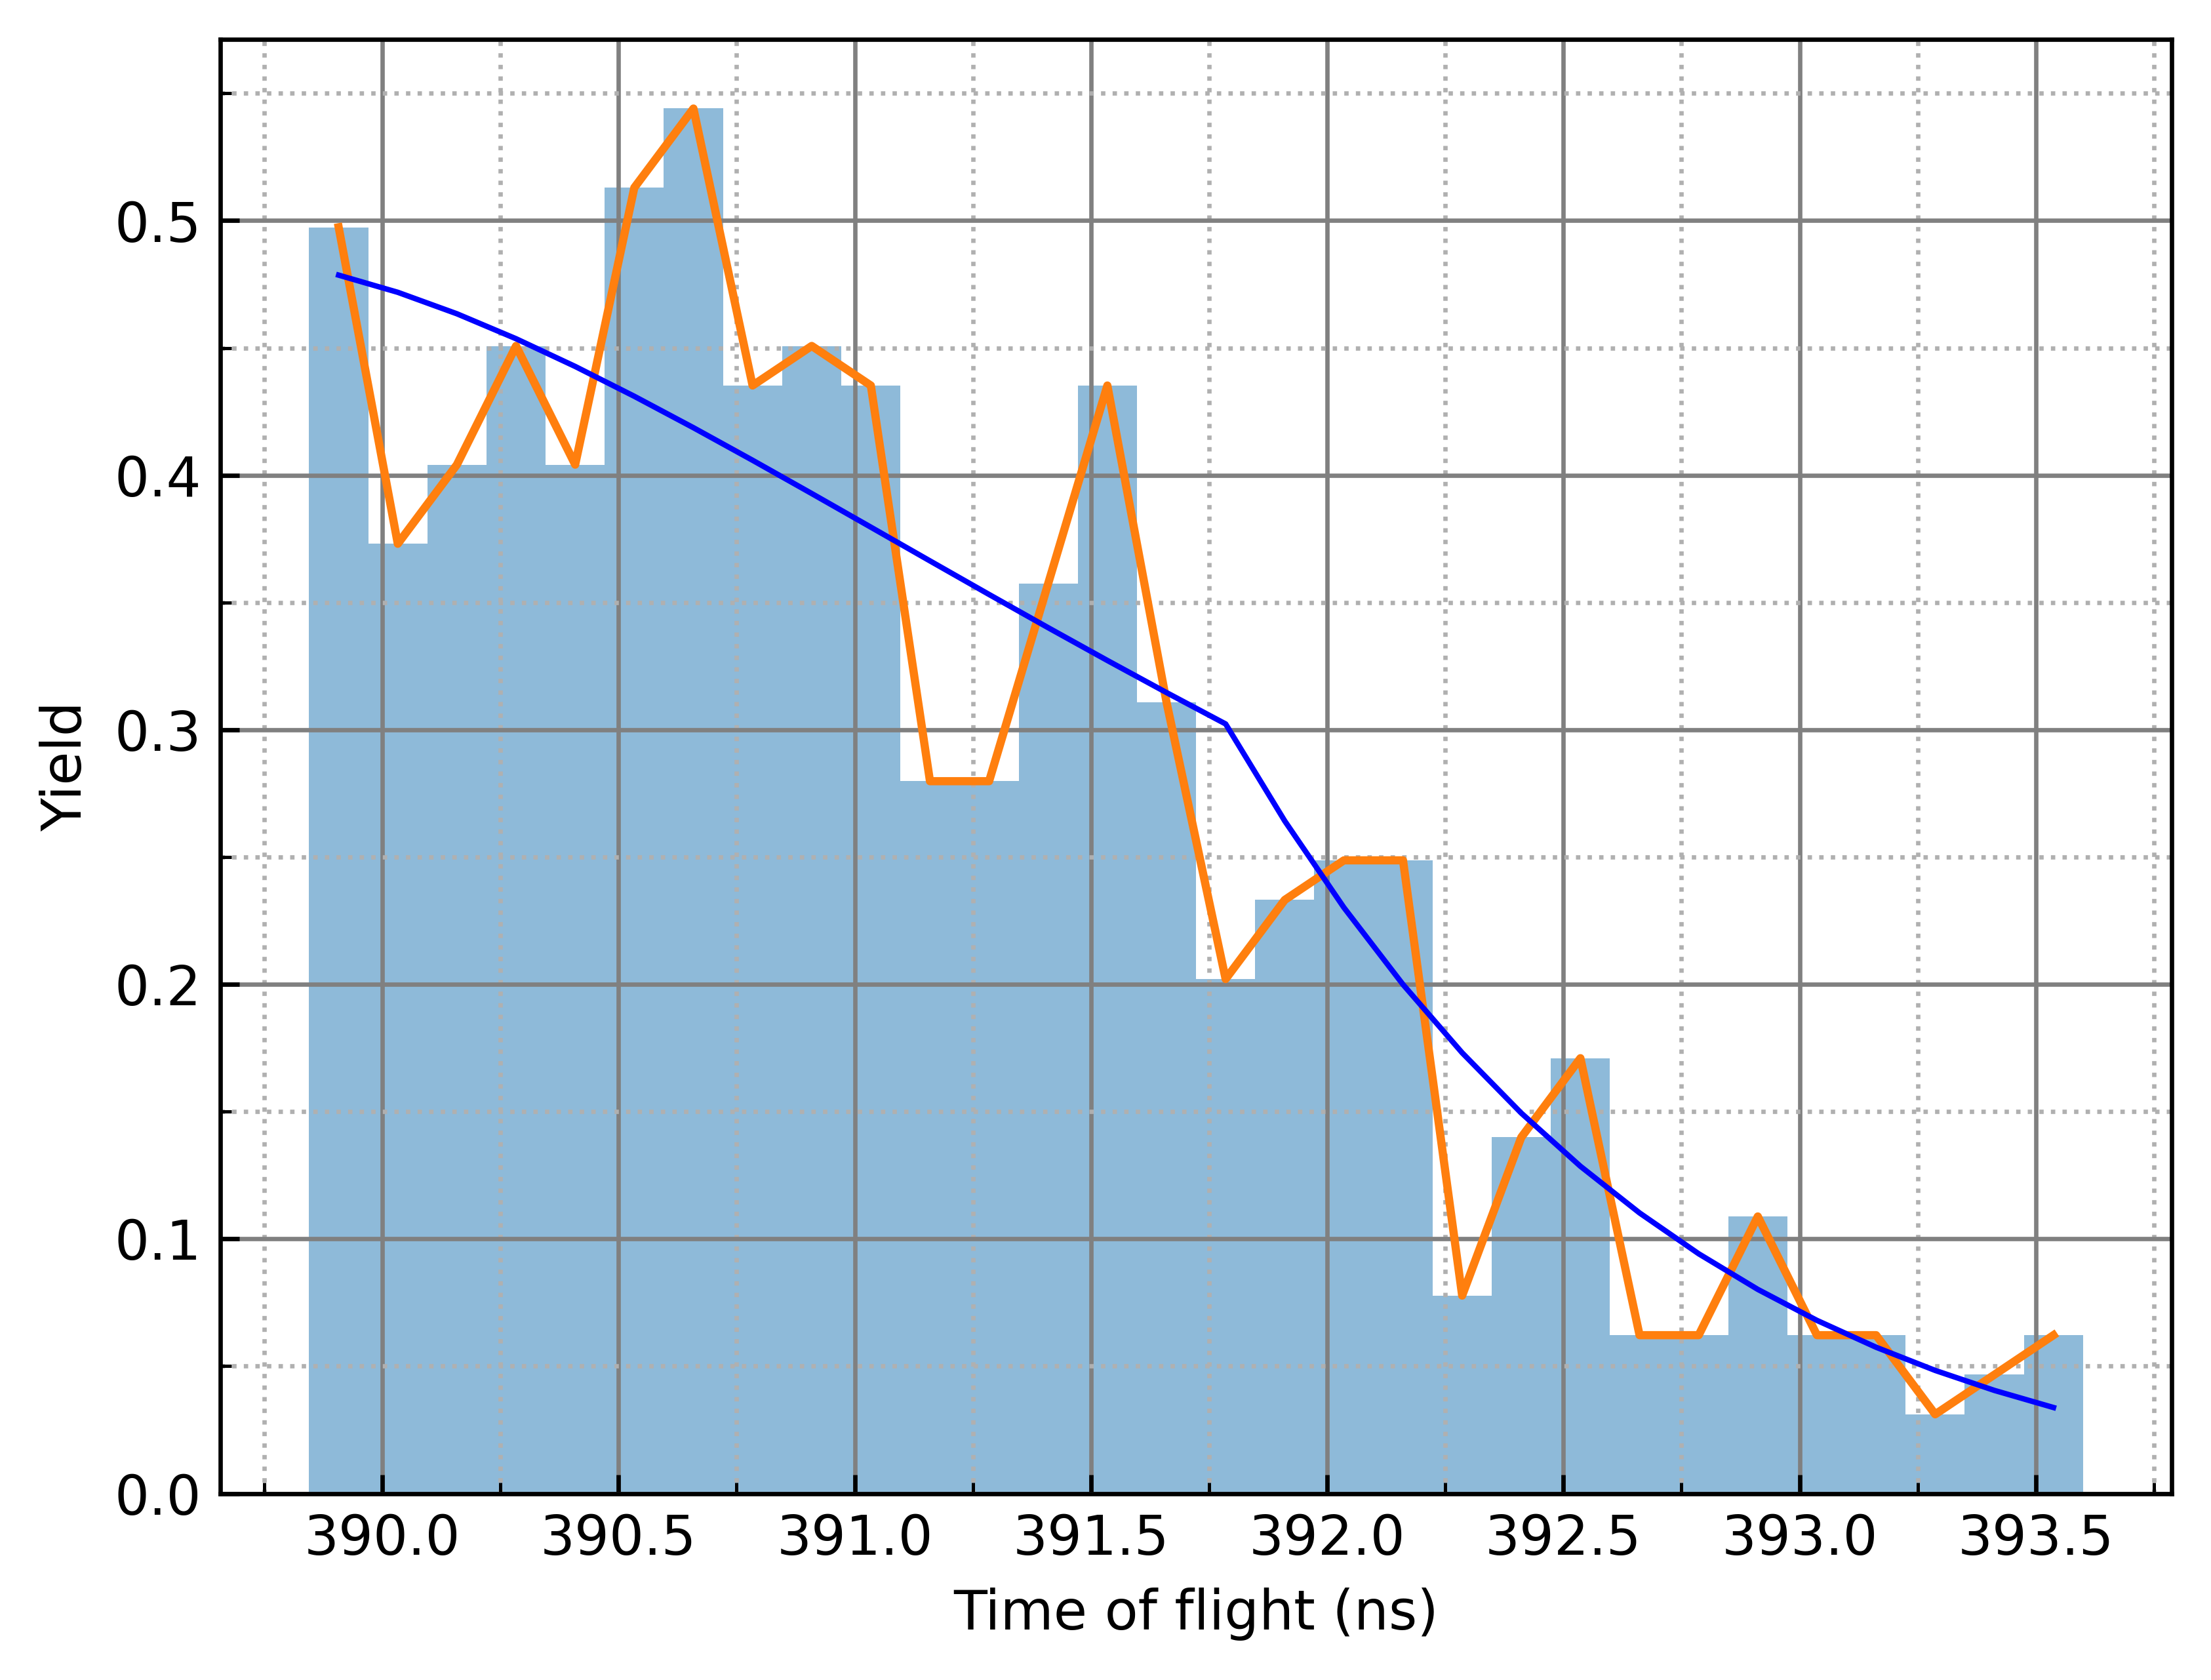

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.signal import peak_widths, find_peaks
from funcs import time_of_flight, decorate

x_start = 389
x_end = 393
x_interval = 0.5
y_start = 0
y_end = 1
y_interval = 0.1

fig, ax = plt.subplots(dpi=600)
d1 = []
with open("./data/1k_29ev.txt", 'r') as f:
    while True:
        s = f.readline()
        if s == '':
                break
        a = s.split()
        d1.append(float(a[0]))

decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"Time of flight (ns)", r"Yield", set=False)

y,x,_=hist(d1,30,alpha=.5, density=True)
x=(x[1:]+x[:-1])/2
ax.plot(x, y)

def improved_gauss(x, x0, sigma, A, t):
    return np.convolve((A/2/np.pi/sigma)*np.exp(-(x-x0)**2/2/sigma**2),
                       np.exp(-(x-x0)/t)*np.heaviside(x-x0, 1), 'same')

params,cov = curve_fit(improved_gauss, x, y, (time_of_flight(23.76), 1, 0, 1))
sigma = sqrt(diag(cov))
new_y = improved_gauss(x, *params)
ax.plot(x, new_y, color='blue', lw=1)

results_half = peak_widths(new_y, (0,), rel_height=0.5)

print(results_half[0])

def e(t):
     return (9.1093837e-31*(1.120/t/1e-9)**2)/2 * 6.242e+18

# import pandas as pd
# d = {
#     "Energy, eV": [200, 199, 198, 197, 196, 195, 194, 193, 192],
#     "Theory, ns": [	time_of_flight(200), time_of_flight(199), time_of_flight(198),
#                     time_of_flight(197), time_of_flight(196), time_of_flight(195),
#                     time_of_flight(194), time_of_flight(193), time_of_flight(192)],
#     "Experiment, ns": [times[0], times[1], times[2], times[3], times[4],
#                         times[5], times[6], times[7], times[8]],
#     "Sigma, ns": [sigmas[0], sigmas[1], sigmas[2], sigmas[3],
#                   sigmas[4], sigmas[5], sigmas[6], sigmas[7], sigmas[8]],
#     "Ex/Th": [	times[0]/time_of_flight(200), times[1]/time_of_flight(199),
#             	times[2]/time_of_flight(198), times[3]/time_of_flight(197),
# 				times[4]/time_of_flight(196), times[5]/time_of_flight(195),
# 				times[6]/time_of_flight(194), times[7]/time_of_flight(193),
# 				times[8]/time_of_flight(192)]
# }
# df = pd.DataFrame(data=d)
# print(x[0]-x[10])
# df